# LSTM based Network Architecture for Binary Classification
(IMDB Movie Dataset)

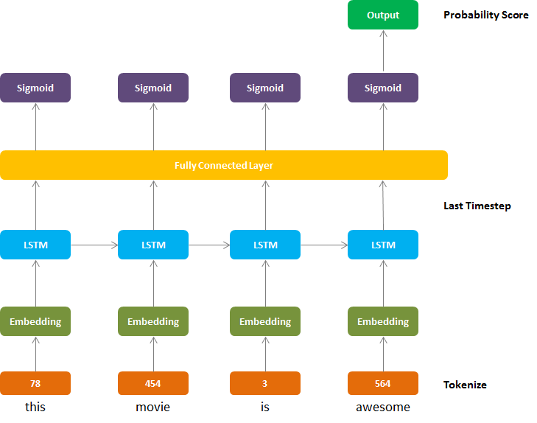

### Various Steps Involved are:
1. Input Data
1. Tokenization
1. Sequence Batching and Data Loaders
1. Embedding Layer
1. LSTM Layer
1. Fully Connected (FC) layer
1. Sigmoid
1. Final Output

In [ ]:
# List of extra libraries used in the project that requires installation

# 1. Beautiful Soup
!pip install bs4

In [ ]:
import torch

import numpy as np 
import pandas as pd 
import re
from collections import Counter

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

df.shape

In [ ]:
df['review_len'] = df['review'].str.len()
df['review_num_words'] = df['review'].str.split().str.len()
df

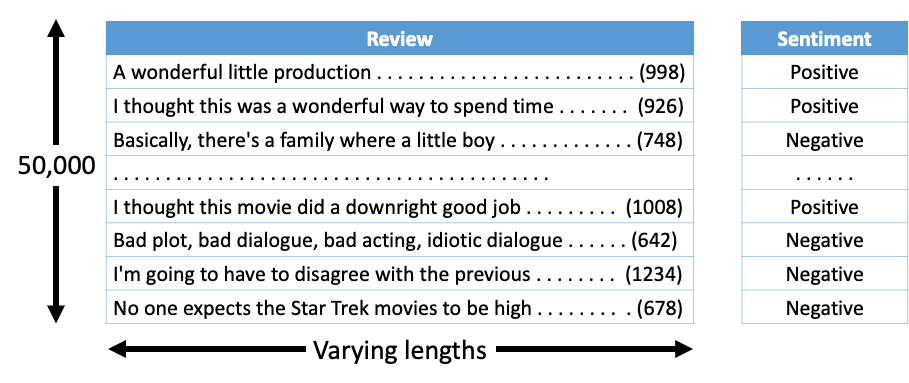

## Look at few review samples to understand what kind of data is present

In [ ]:
df['review'][0]

In [ ]:
df['review'][1]

In [ ]:
df['review'][2]

## We will set up the pipeline for only 1000 reviews. 

Tip: Generally a good idea to work with smaller dataset as the code runs faster and it is easier to debug. However, some of the issues may only surface when you use the complete data so you have to mindfull.

In [ ]:
#df = df.iloc[0:1000,:]
#df.shape

## We observe that the review text would require some cleaning before we use it further.
### Some of the cleaning steps required are :
1. Removing HTML tags
1. Converting into lower case
1. Removing special characters

In [ ]:
def pre_process_text(text):
    
    # Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    
    # Convert to lower case
    text = text.lower()
    
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    return text

In [ ]:
df['review'] = df['review'].apply(pre_process_text)

In [ ]:
df['review'][1]

In [ ]:
df['review_len'] = df['review'].str.len()
df['review_num_words'] = df['review'].str.split().str.len()
df

### Analyze Review Lengths

In [ ]:
fig, ax = plt.subplots(figsize = (14,6))
plt.hist(df['review_len'], bins=40 )
plt.show()

In [ ]:
df['review_len'].describe(percentiles = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100])/100)

### Analyze Number of words in reviews

In [ ]:
fig, ax = plt.subplots(figsize = (14,6))
plt.hist(df['review_num_words'], bins=40 )
plt.show()

## This is how our data looks like 

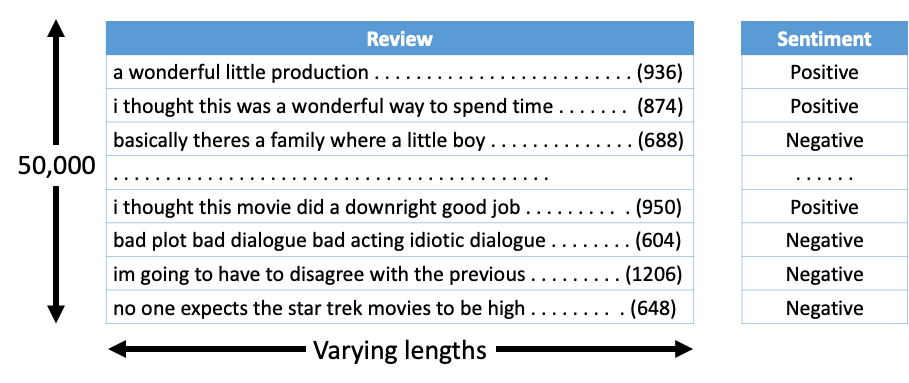

## Word Embeddings:

* In NLP, your features are words. But how should you represent a word in a computer?
    - ASCI Value (This tells you what word is; doesn't tell you anything about what word means)
    - One Hot Vector (Massive dimensional space)
* Fundamental linguistic assumption: that words appearing in similar contexts are related to each other semantically.
* How could we actually encode semantic similarity in words?
    - There can be thousands of semantic attributes that might be relevant. How on earth can you set the value of these attributes?

### Here comes the Central Idea of Deep Learning
* You let Neural Networks learn these representations of the feature i.e. let word embeddings be parameters in the model and then be updated during the training.


Reading reference:
1. [PyTorch Documentation](https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html)
1. [What the heck is word embedding?](https://towardsdatascience.com/what-the-heck-is-word-embedding-b30f67f01c81)

## Tokenize the reviews

### Create word to index mapping dictionary

We will create an index mapping dictionary in such a way that your frequently occurring words are assigned lower indexes. One of the most common way of doing this is to use Counter method from Collections library.


In [ ]:
# Create List of reviews
reviews_list = list(df['review'])
len(reviews_list)

# From list of reviews, we need to get to list of words
all_words = ' '.join(reviews_list)
list_words = all_words.split()

# Count all the words using Counter Method
count_words = Counter(list_words)
total_words = len(list_words)
sorted_words = count_words.most_common(total_words)

# Create vocab_to_in dictionary
vocab_to_int = {w:i for i, (w,c) in enumerate(sorted_words)}

# tokenize reviews
reviews_int = []
for review in reviews_list:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)
    
# Encode Labels
labels_list = list(df['sentiment'])
labels_int = [1 if label =='positive' else 0 for label in labels_list]
labels_int = np.array(labels_int)

In [ ]:
print(total_words)

In [ ]:
sorted_words[0:10]

In [ ]:
dict(list(vocab_to_int.items())[0:10])

In [ ]:
print (reviews_int[0:3])

In [ ]:
print(labels_int[0:3])

# After tokenization this is how our data looks like
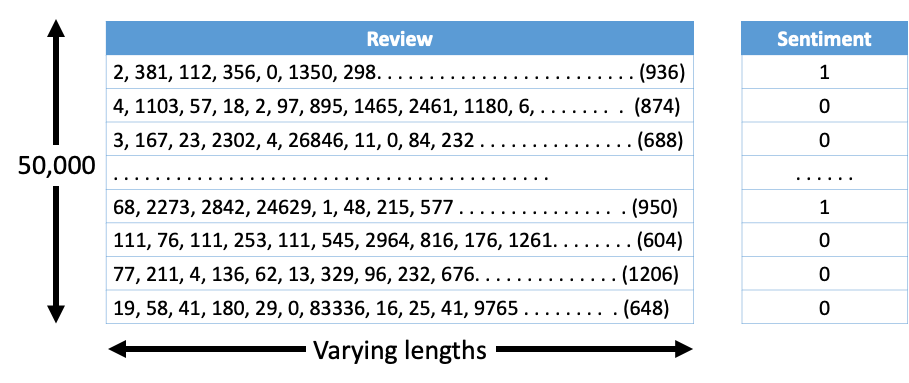

# Define the sequence length

### This sequence length is same as number of time steps for LSTM layer.

* Too long reviews --> Truncate
* Too short reviews --> Delete
* Remaining reviews --> Padding

In [ ]:
def pad_features(reviews_int, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's or truncated to the input seq_length.
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

In [ ]:
seq_length = 2500
features = pad_features(reviews_int, seq_length)

In [ ]:
features[0:3]

# Now Data looks like this
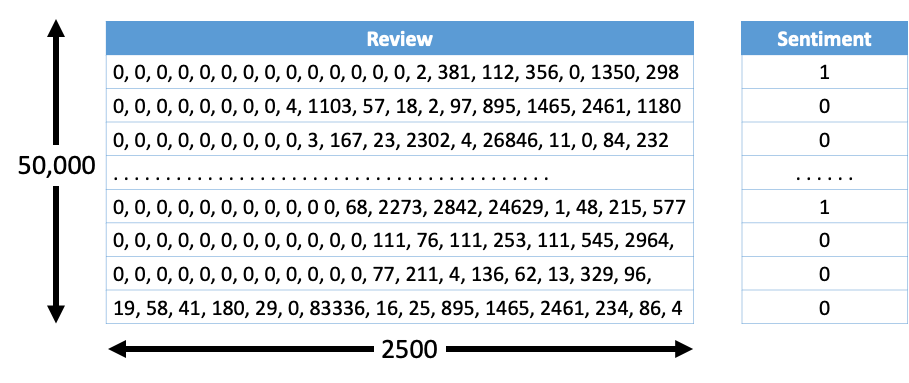

# Training / Validation / Test Split

train= 80% | valid = 10% | test = 10%


In [ ]:
len_feat = len(features)
split_frac = 0.8
train_x = features[0:int(split_frac*len_feat)]
train_y = labels_int[0:int(split_frac*len_feat)]

remaining_x = features[int(split_frac*len_feat):]
remaining_y = labels_int[int(split_frac*len_feat):]

valid_x = remaining_x[0:int(len(remaining_x)*0.5)]
valid_y = remaining_y[0:int(len(remaining_y)*0.5)]

test_x = remaining_x[int(len(remaining_x)*0.5):]
test_y = remaining_y[int(len(remaining_y)*0.5):]

In [ ]:
print(f'Shape of Train X, {len(train_x)}, Shape of Train y, {len(train_y)}')
print(f'Shape of Train X, {len(valid_x)}, Shape of Train y, {len(valid_y)}')
print(f'Shape of Train X, {len(test_x)}, Shape of Train y, {len(test_y)}')

# Data Loaders and Batching

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(valid_x), torch.from_numpy(valid_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Visualize one batch of data 

In [ ]:
# Obtain one batch of training data
dataiter = iter(train_loader)
x, y = dataiter.next()
print('Sample input size: ', x.size()) # batch_size, seq_length
print('Sample input: \n', x)


In [ ]:
print('Sample label size: ', y.size()) # batch_size
print('Sample label: \n', y)

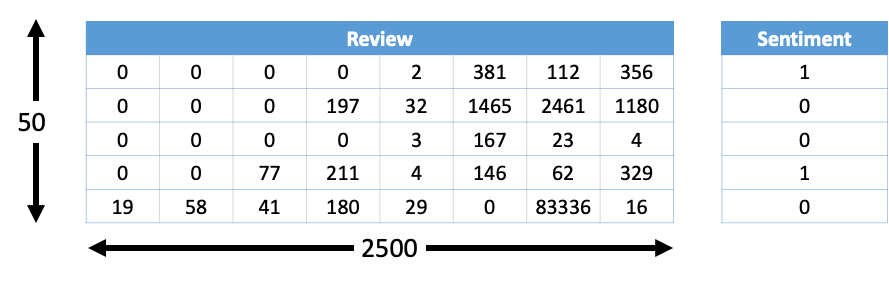

# Add Embedding Layer

In [ ]:
from torch import nn

vocab_size = len(all_words)
embedding_dim = 30

embeds = nn.Embedding(vocab_size, embedding_dim)
print ('Shape of Embedding layer is ', embeds)


In [ ]:
print ('Embedding layer weights ', embeds.weight.shape)

In [ ]:
embeds_out = embeds(x)

print ('Embedding layer output shape', embeds_out.shape)
print ('Embedding layer output ', embeds_out)

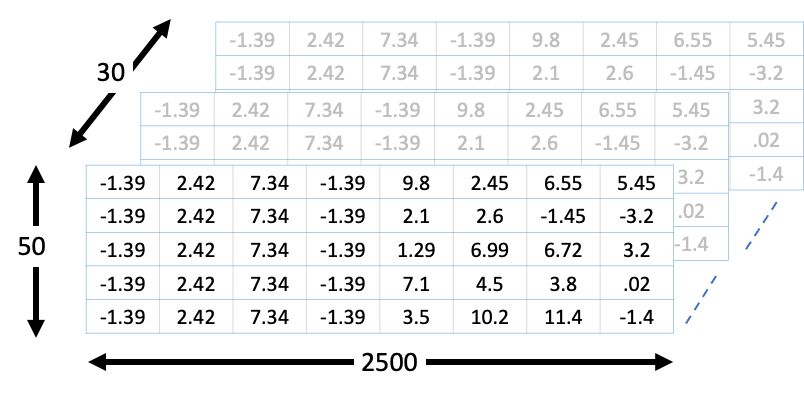

# Add LSTM Layer

In [ ]:
# initializing the hidden state to 0
hidden=None
hidden_units = 512

lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_units, num_layers=1, batch_first=True)
lstm_out, h = lstm(embeds_out, hidden)
print ('LSTM layer output shape', lstm_out.shape)
print ('LSTM layer output ', lstm_out)

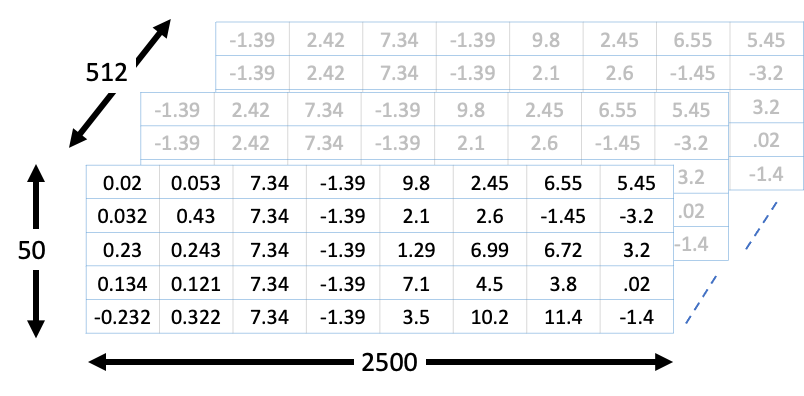


# Fully Connected Layer

In [ ]:
fc = nn.Linear(in_features=hidden_units, out_features=1)

fc_out = fc(lstm_out.contiguous().view(-1, hidden_units))

print ('FC layer output shape', fc_out.shape)
print ('FC layer output ', fc_out)

In [ ]:
50*2500

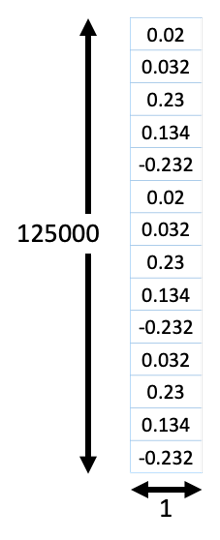

# Sigmoid Activation Layer

In [ ]:
sigm = nn.Sigmoid()
sigm_out = sigm(fc_out)
print ('Sigmoid layer output shape', sigm_out.shape)
print ('Sigmoid layer output ', sigm_out)

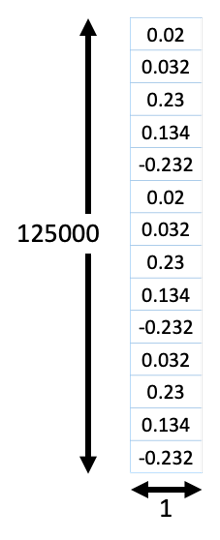

# Final Output :
### This includes 2 steps

### Step 1) Reshape the output so that rows = batch_size

In [ ]:
out = sigm_out.view(batch_size, -1)
print ('Output layer output shape', out.shape)
print ('Output layer output ', out)

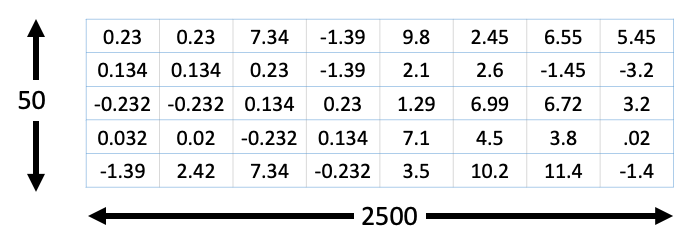

### Step 2) Output from the last timestep

In [ ]:
final_output = out[:,-1]
print ('Final Output Shape , ', final_output.shape)
print ('Final sentiment prediction, ', final_output)

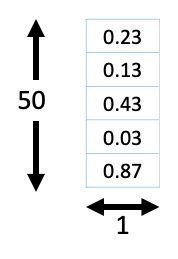